In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchmetrics import Accuracy

try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find the torchinfo...\n Installing it.....")
    !pip install -qq torchinfo
    from torchinfo import summary

# Setup Summary writer
try:
    from torch.utils.tensorboard import SummaryWriter
except:
    print(f'[INFO]: Could not find tensorboard..... installing it!! ')
    !pip install -qq tensorboard
    from torch.utils.tensorboard import SummaryWriter

# Try to import going_moduler directory. download it from GitHub, if it doesn't work
try:
    from going_modular import data_setup, engine, utils
except:
    print(f"[INFO] Couldn't find the directory...\n Downloading it from github.....")
    !git clone https://github.com/Niloy009/learning_pytorch.git
    !mv leaning_pytorch/going_modular .
    !rm -rf learning_pytorch
    from going_modular import data_setup, engine, utils

In [2]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
# Set the seed
def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """

    # set the seed for the general torch operation
    torch.manual_seed(seed)

    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

# Get the data

In [4]:
import os
import zipfile

from pathlib import Path

import requests



def download_data(source: str, 
                  destination: str, 
                  remove_source: bool = True) -> Path:
    """Download a ziped dataset from source and unzip to destination

    Args:
        source: The source path where the data will download from.
        destination: The destination path where the data will download and unzip to.
        remove_source: Whether the source remove or not after download.
        
    Returns:
        pathlib.Path to downloaded data.
    """


    # Setup data path
    data_path = Path("data/")
    image_path = data_path / destination # images from a subset of classes from the Food101 dataset

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
      print(f"[INFO] {image_path} directory exists, skipping re-download.")
    else:
      print(f"[INFO] Did not find {image_path}, downloading it...")
      image_path.mkdir(parents=True, exist_ok=True)

      # Download pizza, steak, sushi data
      target_file = Path(source).name
      with open(data_path / target_file, "wb") as f:
        request = requests.get(source)
        print(f"[INFO] Downloading {target_file} from {source}...")
        f.write(request.content)
  
      # unzip pizza, steak, sushi data
      with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
        print(f"[INFO] Unzipping {target_file}...")
        zip_ref.extractall(image_path)
  
      # Remove .zip file
      if remove_source:
          os.remove(data_path / target_file)

    return image_path

In [6]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", 
              destination="pizza_steak_sushi")

[INFO] data/pizza_steak_sushi directory exists, skipping re-download.


# Manual Transform and create dataset and dataloader

In [7]:
# Setup directories
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [8]:
# Setup ImageNet normalization levels (turns all images into similar distribution as ImageNet)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])           
print(f"[INFO] Manually created transforms: {manual_transforms}")

train_dataloader_manual, test_dataloaler_manual, class_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                                test_dir=test_dir, 
                                                                                transform=manual_transforms, 
                                                                                batch_size=32)
train_dataloader_manual, test_dataloaler_manual, class_names

[INFO] Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


(<torch.utils.data.dataloader.DataLoader at 0x7fcd8fd3a510>,
 ['pizza', 'steak', 'sushi'])

# Automate Transform

In [8]:
# Setup pretrained weights (plenty of these available in torchvision.models)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Get transforms from weights (these are the transforms that were used to obtain the weights)
automatic_transforms = weights.transforms() 
print(f"[INFO] Automatically created transforms: {automatic_transforms}")


train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir, 
                                                                                test_dir=test_dir, 
                                                                                transform=automatic_transforms, 
                                                                                batch_size=32)
train_dataloader, test_dataloader, class_names

[INFO] Automatically created transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


(<torch.utils.data.dataloader.DataLoader at 0x7fc6c4ae52e0>,
 ['pizza', 'steak', 'sushi'])

# Get Pretrained Model 

In [9]:
# Download the weights of pretrained model Efficientnet_B0
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# Set up the model with weights and send it to the device
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

# View the model
# model

In [10]:
# Freeze all base layers by setting attribute required_grad to False
for param in model.features.parameters():
    param.requires_grad = False

# Since we're creating a new layer with random weights (torch.nn.Linear), 
# let's set the seeds
set_seeds()

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names), bias=True)
)


In [6]:
# Get a summary of the model
summary(model=model, 
        input_size=(32,3,224,224), 
        verbose=0, 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width=18, row_settings=['var_names'])


NameError: name 'model' is not defined

# Train a single model and track it

In [12]:
# Define loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
accuracy = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

In [8]:

writer = SummaryWriter()
writer


In [14]:
import torchmetrics
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          loss_fn: torch.nn.Module, 
          optimizer: torch.optim.Optimizer,
          accuracy: torchmetrics.classification.accuracy.Accuracy,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and test a PyTorch model

    Passes a target PyTorch model through train_step() and test_step()
    functions for a number of epochs. training and testing the model in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
        model: A PyTorch model to be tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        loss_fn: A PyTorch loss function to calculate loss on the test data.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        accuracy: A torchmetric module to calculate accuracy.
        epochs: An integar indicating how many epochs to train for.
        device: A target device to compute on (i.e. "cuda" or "cpu")

    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics. Each metric has a value in a list for 
        each epoch.
        In the form: {train_loss: [...],
                      train_acc: [...],
                      test_loss: [...],
                      test_acc: [...]} 
        For example if training for epochs=2: 
                     {train_loss: [2.0616, 1.0537],
                      train_acc: [0.3945, 0.3945],
                      test_loss: [1.2641, 1.5706],
                      test_acc: [0.3400, 0.2973]} 
  """
    # Create empty results dictionary
    results = { "train_loss": [], 
                "train_accuracy": [], 
                "test_loss": [], 
                "test_accuracy": []
              }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model=model, 
                                                dataloader=train_dataloader, 
                                                loss_fn=loss_fn, 
                                                optimizer=optimizer, 
                                                accuracy=accuracy, 
                                                device=device)
        test_loss, test_accuracy = test_step(model=model, 
                                             dataloader=test_dataloader, 
                                             loss_fn=loss_fn,
                                             accuracy=accuracy, 
                                             device=device)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss: .4f} | "
            f"train_accuracy: {train_accuracy: .4f} | "
            f"test_loss: {test_loss: .4f} | "
            f"test_accuracy: {test_accuracy: .4f}"
        )
        # 5. update the results
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)

        #### New: Experiment tracking with tensorboard ####
        writer.add_scalars(main_tag="Loss", 
                           tag_scalar_dict={"train_loss": train_loss, 
                                            "test_loss": test_loss}, 
                           global_step=epoch)
        
        writer.add_scalars(main_tag="Accuracy", 
                           tag_scalar_dict={"train_accuracy": train_accuracy, 
                                            "test_accuracy": test_accuracy}, 
                           global_step=epoch)

        writer.add_graph(model=model, input_to_model=torch.randn(32,3,224,224).to(device))

        # Close the writer
        writer.close()

        #### End: Experiment tracking with tensorboard ####
        

    return results



In [15]:
# Train Model
# Note: Not using engine.train() as we modified the function above

set_seeds()
results = train(model=model, 
                train_dataloader=train_dataloader, 
                test_dataloader=test_dataloader, 
                loss_fn=loss_fn, 
                optimizer=optimizer,
                accuracy=accuracy, 
                epochs=5, 
                device=device)


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss:  1.0948 | train_accuracy:  0.3984 | test_loss:  0.9034 | test_accuracy:  0.6411
Epoch: 2 | train_loss:  0.9005 | train_accuracy:  0.6445 | test_loss:  0.7874 | test_accuracy:  0.8561
Epoch: 3 | train_loss:  0.8115 | train_accuracy:  0.7500 | test_loss:  0.6749 | test_accuracy:  0.8759
Epoch: 4 | train_loss:  0.6853 | train_accuracy:  0.7383 | test_loss:  0.6704 | test_accuracy:  0.8352
Epoch: 5 | train_loss:  0.7091 | train_accuracy:  0.7383 | test_loss:  0.6768 | test_accuracy:  0.8040


In [16]:
# Lets view our experiment
# %load_ext tensorboard
# %tensorboard --logdir runs

# Create a function to prepare a `SummaryWriter()` instance

By default our `SummaryWriter()` class aves to `log_dir`.

How about if we wanted to save different experiments to different folders?

in simple word **one experiment = one folder**

For example, we'd like to track:

* Experiment data/timestamp
* Experiment name
* Model name
* Extra - is there anything else that should be tracked?

Let's create a function to create a `SummaryWriter()` instance to take all of these things into account.

So ideally we end up tracking experiment to a directory:

`runs/YYYY-MM-DD/experiment_name/model_name/extra`


In [5]:
from datetime import datetime
import os

from torch.utils.tensorboard import SummaryWriter

def create_writer(experiment_name: str, model_name: str, extra: str = None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Create a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir
    
    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra

    Where timestamp is current date in YYYY-MM-DD format

    Args:
        experiment_name (str): Name of the experiment.
        model_name (str): Name of the model
        extra (str, optional): Anything extra to add to the directory.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to the specific log_dir.

    Example usage:
        # Create a writer saving to "runs/2025-Apr-05/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """

    # Get timestamp of current date in reverse order (YYYY-MM-DD)
    timestamp = datetime.now().strftime("%Y-%b-%d")

    if extra:
        # create log directory path
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join('runs', timestamp, experiment_name, model_name)

    print(f"[INFO] Created SummaryWriter saving to {log_dir}")
    return SummaryWriter(log_dir=log_dir)
    

In [18]:
example_writer = create_writer(experiment_name='data_10_percent', model_name="efficientnetb0", extra='5_epochs')
example_writer

[INFO] Created SummaryWriter saving to runs/2025-Apr-06/data_10_percent/efficientnetb0/5_epochs


In [19]:
import torchmetrics
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step


def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          loss_fn: torch.nn.Module, 
          optimizer: torch.optim.Optimizer,
          accuracy: torchmetrics.classification.accuracy.Accuracy,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter) -> Dict[str, List]:
    """Trains and test a PyTorch model

    Passes a target PyTorch model through train_step() and test_step()
    functions for a number of epochs. training and testing the model in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.
    
    Stores metrics to specified writer log_dir if present.
    
    Args:
        model: A PyTorch model to be tested.
        train_dataloader: A DataLoader instance for the model to be trained on.
        test_dataloader: A DataLoader instance for the model to be tested on.
        loss_fn: A PyTorch loss function to calculate loss on the test data.
        optimizer: A PyTorch optimizer to help minimize the loss function.
        accuracy: A torchmetric module to calculate accuracy.
        epochs: An integar indicating how many epochs to train for.
        device: A target device to compute on (i.e. "cuda" or "cpu").
        writer: A SummaryWriter() instance to log model results to.


    Returns:
        A dictionary of training and testing loss as well as training and
        testing accuracy metrics. Each metric has a value in a list for 
        each epoch.
        In the form: {train_loss: [...],
                      train_acc: [...],
                      test_loss: [...],
                      test_acc: [...]} 
        For example if training for epochs=2: 
                     {train_loss: [2.0616, 1.0537],
                      train_acc: [0.3945, 0.3945],
                      test_loss: [1.2641, 1.5706],
                      test_acc: [0.3400, 0.2973]} 
  """
    # Create empty results dictionary
    results = { "train_loss": [], 
                "train_accuracy": [], 
                "test_loss": [], 
                "test_accuracy": []
              }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model=model, 
                                                dataloader=train_dataloader, 
                                                loss_fn=loss_fn, 
                                                optimizer=optimizer, 
                                                accuracy=accuracy, 
                                                device=device)
        test_loss, test_accuracy = test_step(model=model, 
                                             dataloader=test_dataloader, 
                                             loss_fn=loss_fn,
                                             accuracy=accuracy, 
                                             device=device)
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss: .4f} | "
            f"train_accuracy: {train_accuracy: .4f} | "
            f"test_loss: {test_loss: .4f} | "
            f"test_accuracy: {test_accuracy: .4f}"
        )
        # 5. update the results
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["test_loss"].append(test_loss)
        results["test_accuracy"].append(test_accuracy)

        #### New: Experiment tracking with tensorboard ####
        if writer:
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss, 
                                                "test_loss": test_loss}, 
                               global_step=epoch)
            
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_accuracy": train_accuracy, 
                                                "test_accuracy": test_accuracy}, 
                               global_step=epoch)
    
            writer.add_graph(model=model, input_to_model=torch.randn(32,3,224,224).to(device))
    
            # Close the writer
            writer.close()
        else:
            pass

        #### End: Experiment tracking with tensorboard ####
        

    return results



# Experiment Tracking

### What kind of experiments should you run?

The number of machine learning experiments you can run, is like the number of different modela you can build... almost limitless.

However, you can't test everything...

So what should you test?
* Change the number of **epochs.**
* Chnage the number of **hidden layers/units.**
* Change the **amount of data** (right now we're using 10% of the Food101 dataset for pizza, steak, sushi)
* Change the **learning rate**
* Try different kinds of **data augmentation**
* Choose a different **model architecture.** 

This is why transfer learning is so powerful, beacause it is working model that you can apply to your own problem.

### What experiments are we going to run?
We are going to turn three dials:
1. Model Size - EffnetB0 vs EffnetB2 (in terms of number of parameters)
2. Dataset Size - 10% of pizza, steak, sushi images vs 20% (Generally more data = better results)
3. Training Time - 5 epochs vs 10 epochs (Generally longer training time = better results, up to a point)

To begin, we're still keeping things relatively snalll to that our experiments run quickly.


**Our Goal:** A model that is well performing but still small enough to run on a mobile device or web browser so FoodVision Mini can come to life.


If you had infinite compute + time, you should basically always choose the biggest model and biggest dataset you can. ([The Bitter Lesson](http://www.incompleteideas.net/IncIdeas/BitterLesson.html))

The total 8 exeriments we want to do are follows:

| Experiment Number | Training Dataset | Testing Dataset | Model  | Epochs |
|------------|--------------------------------|--------------------|--------------------|--------|
| 1          | Pizza, Steak, Sushi **(10%)**  | Pizza, Steak, Sushi **(10%)** | EfficientNetB0     | 5      |
| 2          | Pizza, Steak, Sushi **(10%)**  | Same as experiment number 1   | EfficientNetB2     | 5      |
| 3          | Pizza, Steak, Sushi **(10%)**  | Same as experiment number 1   | EfficientNetB0     | 10     |
| 4          | Pizza, Steak, Sushi **(10%)**  | Same as experiment number 1   | EfficientNetB2     | 10     |
| 5          | Pizza, Steak, Sushi **(20%)**  | Same as experiment number 1   | EfficientNetB0     | 5      |
| 6          | Pizza, Steak, Sushi **(20%)**  | Same as experiment number 1   | EfficientNetB2     | 5      |
| 7          | Pizza, Steak, Sushi **(20%)**  | Same as experiment number 1   | EfficientNetB0     | 10     |
| 8          | Pizza, Steak, Sushi **(20%)**  | Same as experiment number 1   | EfficientNetB2     | 10     |


# 1. Start by downloading Data

Now we're going to experiment total 8 experiments to track. For this we choose 2 types (in sense of amount) of data.

1. Pizza, Steak, Sushi - 10% data ([link](https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip))
2. Pizza, Steak, Sushi - 20% data ([link](https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip))


In [6]:
# Download 10 percent and 20 percent datasets
data_10_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip", 
                                destination="pizza_steak_sushi_10")

data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip", 
                                    destination='pizza_steak_sushi_20')



[INFO] data/pizza_steak_sushi_10 directory exists, skipping re-download.
[INFO] data/pizza_steak_sushi_20 directory exists, skipping re-download.


# 1.1 Turn the Dataset in to DataLoaders

In [7]:
# Get the train and test path
train_10_dir = data_10_percent_path / 'train'
train_20_dir = data_20_percent_path / 'train'

test_10_dir = data_10_percent_path / 'test'

train_10_dir, train_20_dir, test_10_dir

(PosixPath('data/pizza_steak_sushi_10/train'),
 PosixPath('data/pizza_steak_sushi_20/train'),
 PosixPath('data/pizza_steak_sushi_10/test'))

In [8]:
def create_transform_weights(model_weight):
    """ Create transforms by using pretrained model best weights
    Args:
        model_weight: A pretrained model's weight from torchvision
    Return:
        A tuple of weights and transforms
    """
    # Setup pretrained weights
    weights = model_weight.DEFAULT

    transforms = weights.transforms()

    print(f'[INFO] Creating Transform from pretrained model best weights: {transforms}')

    return weights, transforms


In [9]:
# Setup the Batch Size
BATCH_SIZE = 32

# Setup best weights and transforms based on best weights
effnet_b0_weights, effnet_b0_transform = create_transform_weights(model_weight=torchvision.models.EfficientNet_B0_Weights)

# # Setup pretrained weights
# effnet_b0_weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT

# # Get the transform of the pretrained model best weights
# effnet_b0_transform = effnet_b0_weights.transforms()
# print(f'[INFO] Creating Transform from pretrained model best weights: {effnet_b0_transform}')

# Create the dataloaders for 10%
train_dataloader_10, test_datalaoder, class_names = data_setup.create_dataloaders(train_dir=train_10_dir, 
                                                                                     test_dir=test_10_dir, 
                                                                                     transform=effnet_b0_transform, 
                                                                                     batch_size=BATCH_SIZE)
# Create the dataloaders for 20%
train_dataloader_20, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_20_dir, 
                                                                                 test_dir=test_10_dir, 
                                                                                 transform=effnet_b0_transform, 
                                                                                 batch_size=BATCH_SIZE)


print(f'[INFO] Number of batches of size {BATCH_SIZE} in 10% train data: {len(train_dataloader_10)}')
print(f'[INFO] Number of batches of size {BATCH_SIZE} in 20% train data: {len(train_dataloader_20)}')
print(f'[INFO] Number of batches of size {BATCH_SIZE} in 10% test data: {len(test_dataloader)}')
print(f'[INFO] Class names: {class_names} & length of the class: {len(class_names)}')


[INFO] Creating Transform from pretrained model best weights: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
[INFO] Number of batches of size 32 in 10% train data: 8
[INFO] Number of batches of size 32 in 20% train data: 15
[INFO] Number of batches of size 32 in 10% test data: 3
[INFO] Class names: ['pizza', 'steak', 'sushi'] & length of the class: 3


# 1.2 Create feature extractor models

Create 2 functions for EffnetB0 and EffnetB2 to make feature extractor models

In [10]:
import torchvision
from torch import nn

# Get num of the output features
OUT_FEATURE = len(class_names)


# Create an EffnetB0 feature extractor
def create_effnetb0():
    # get the pretrained weights nad base model
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # set the seeds
    set_seeds()

    # Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=OUT_FEATURE)
    ).to(device)
    
    # give the model name
    model.name = 'effnetb0'
    print(f"[INFO] Created new {model.name} model")
    return model

# Create an EffnetB2 feature extractor
def create_effnetb2():
    # get the pretrained weights nad base model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    # Freeze the base model layers
    for param in model.features.parameters():
        param.requires_grad = False

    # set the seeds
    set_seeds()

    # Change the classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=OUT_FEATURE)
    ).to(device)
    
    # give the model name
    model.name = 'effnetb2'
    print(f"[INFO] Created new {model.name} model")
    return model

In [11]:
effnetb0_model = create_effnetb0()
effnetb2_model = create_effnetb2()

summary(model=effnetb0_model, 
        input_size=(32, 3, 224, 224), 
        verbose=0, 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width=18, 
        row_settings=['var_names'])

[INFO] Created new effnetb0 model
[INFO] Created new effnetb2 model


Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]  [32, 3]            --                 Partial
├─Sequential (features)                                      [32, 3, 224, 224]  [32, 1280, 7, 7]   --                 False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]  [32, 32, 112, 112] --                 False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]  [32, 32, 112, 112] (864)              False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)               False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --                 False
│    

In [12]:
summary(model=effnetb2_model, 
        input_size=(32, 3, 224, 224), 
        verbose=0, 
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], 
        col_width=18, 
        row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape        Output Shape       Param #            Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]  [32, 3]            --                 Partial
├─Sequential (features)                                      [32, 3, 224, 224]  [32, 1408, 7, 7]   --                 False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]  [32, 32, 112, 112] --                 False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]  [32, 32, 112, 112] (864)              False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112] [32, 32, 112, 112] (64)               False
│    │    └─SiLU (2)                                         [32, 32, 112, 112] [32, 32, 112, 112] --                 --
│    └─Sequential (1)                                        [32, 32, 112, 112] [32, 16, 112, 112] --                 False
│    

# 1.3 Create experiments and set up training mode

In [13]:
# Create epoch list
num_epochs = [5,10]

# Create model list (need to create a new mdoel for each experiment)
models = ['effnetb0', 'effnetb2']

# Create a DataLoaders dictionary
train_dataloaders = {'data_10_percent': train_dataloader_10, 
                     'data_20_percent':  train_dataloader_20}

In [15]:
%%time
from going_modular.utils import save_model
from going_modular import engine

# Set Seeds
set_seeds()

# Keep track of experiment numbers
experiment_number = 0

# Loop through each DataLoaders
for dataloader_name, train_dataloader in train_dataloaders.items():
    # Loop through the epochs
    for epochs in num_epochs:
        # Loop through the model name and Create a new model instance
        for model_name in models:
            
            experiment_number += 1
            
            # Print out the info
            print(f"[INFO] Experminet Number: {experiment_number}")
            print(f"[INFO] Model: {model_name}")
            print(f"[INFO] DataLoader: {dataloader_name}")
            print(f"[INFO] Number of Epochs: {epochs}")

            # Select and Create the model
            if model_name == 'effnetb0':
                model = create_effnetb0()
            else:
                model = create_effnetb2()
            
            # Create a new loss, optimizer and accuracy for every model
            loss_fn = nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)
            accuracy = Accuracy(task='multiclass', num_classes=len(class_names)).to(device)

            # Train target model with target dataloader and track experiment
            engine.train(model=model, 
                         train_dataloader=train_dataloader, 
                         test_dataloader=test_dataloader, 
                         loss_fn=loss_fn, 
                         optimizer=optimizer, 
                         accuracy=accuracy, 
                         epochs=epochs, 
                         device=device, 
                         writer=create_writer(experiment_name=dataloader_name, 
                                              model_name=model_name, extra=f"{epochs}_epochs"))
            
            # Save the model to file so we can import it later if needed
            save_file_path = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
            save_model(model=model, target_dir='models', model_name=save_file_path)
            print("-"*50 + "\n")  

[INFO] Experminet Number: 1
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 5
[INFO] Created new effnetb0 model
[INFO] Created SummaryWriter saving to runs/2025-Aug-14/data_10_percent/effnetb0/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss:  1.0305 | train_accuracy:  0.5234 | test_loss:  0.8730 | test_accuracy:  0.6723
Epoch: 2 | train_loss:  0.9255 | train_accuracy:  0.5547 | test_loss:  0.8131 | test_accuracy:  0.6723
Epoch: 3 | train_loss:  0.8152 | train_accuracy:  0.7266 | test_loss:  0.7184 | test_accuracy:  0.8049
Epoch: 4 | train_loss:  0.7144 | train_accuracy:  0.7773 | test_loss:  0.6243 | test_accuracy:  0.8759
Epoch: 5 | train_loss:  0.5909 | train_accuracy:  0.8789 | test_loss:  0.5922 | test_accuracy:  0.8873
[INFO] Saving model to: models/07_effnetb0_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experminet Number: 2
[INFO] Model: effnetb2
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 5
[INFO] Created new effnetb2 model
[INFO] Created SummaryWriter saving to runs/2025-Aug-14/data_10_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss:  1.0987 | train_accuracy:  0.3477 | test_loss:  0.9434 | test_accuracy:  0.7112
Epoch: 2 | train_loss:  0.8994 | train_accuracy:  0.6328 | test_loss:  0.8609 | test_accuracy:  0.8362
Epoch: 3 | train_loss:  0.8377 | train_accuracy:  0.6797 | test_loss:  0.7666 | test_accuracy:  0.8153
Epoch: 4 | train_loss:  0.7078 | train_accuracy:  0.8359 | test_loss:  0.6758 | test_accuracy:  0.8759
Epoch: 5 | train_loss:  0.6985 | train_accuracy:  0.7344 | test_loss:  0.6200 | test_accuracy:  0.9062
[INFO] Saving model to: models/07_effnetb2_data_10_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experminet Number: 3
[INFO] Model: effnetb0
[INFO] DataLoader: data_10_percent
[INFO] Number of Epochs: 10
[INFO] Created new effnetb0 model
[INFO] Created SummaryWriter saving to runs/2025-Aug-14/data_10_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss:  1.0305 | train_accuracy:  0.5234 | test_loss:  0.8730 | test_accuracy:  0.6723
Epoch: 2 | train_loss:  0.9255 | train_accuracy:  0.5547 | test_loss:  0.8131 | test_accuracy:  0.6723
Epoch: 3 | train_loss:  0.8152 | train_accuracy:  0.7266 | test_loss:  0.7184 | test_accuracy:  0.8049
Epoch: 4 | train_loss:  0.7144 | train_accuracy:  0.7773 | test_loss:  0.6243 | test_accuracy:  0.8759
Epoch: 5 | train_loss:  0.5909 | train_accuracy:  0.8789 | test_loss:  0.5922 | test_accuracy:  0.8873
Epoch: 6 | train_loss:  0.5639 | train_accuracy:  0.8594 | test_loss:  0.6159 | test_accuracy:  0.7841
Epoch: 7 | train_loss:  0.6041 | train_accuracy:  0.7461 | test_loss:  0.5939 | test_accuracy:  0.8352
Epoch: 8 | train_loss:  0.4764 | train_accuracy:  0.9180 | test_loss:  0.5281 | test_accuracy:  0.8655
Epoch: 9 | train_loss:  0.4592 | train_accuracy:  0.9297 | test_loss:  0.5215 | test_accuracy:  0.8655
Epoch: 10 | train_loss:  0.5609 | train_accuracy:  0.7617 | test_loss:  0

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss:  1.0987 | train_accuracy:  0.3477 | test_loss:  0.9434 | test_accuracy:  0.7112
Epoch: 2 | train_loss:  0.8994 | train_accuracy:  0.6328 | test_loss:  0.8609 | test_accuracy:  0.8362
Epoch: 3 | train_loss:  0.8377 | train_accuracy:  0.6797 | test_loss:  0.7666 | test_accuracy:  0.8153
Epoch: 4 | train_loss:  0.7078 | train_accuracy:  0.8359 | test_loss:  0.6758 | test_accuracy:  0.8759
Epoch: 5 | train_loss:  0.6985 | train_accuracy:  0.7344 | test_loss:  0.6200 | test_accuracy:  0.9062
Epoch: 6 | train_loss:  0.5878 | train_accuracy:  0.8828 | test_loss:  0.6288 | test_accuracy:  0.9072
Epoch: 7 | train_loss:  0.6021 | train_accuracy:  0.8164 | test_loss:  0.5740 | test_accuracy:  0.8968
Epoch: 8 | train_loss:  0.5351 | train_accuracy:  0.7969 | test_loss:  0.5615 | test_accuracy:  0.8769
Epoch: 9 | train_loss:  0.4912 | train_accuracy:  0.7969 | test_loss:  0.5327 | test_accuracy:  0.8759
Epoch: 10 | train_loss:  0.5173 | train_accuracy:  0.8164 | test_loss:  0

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss:  0.9556 | train_accuracy:  0.5687 | test_loss:  0.6683 | test_accuracy:  0.9271
Epoch: 2 | train_loss:  0.7117 | train_accuracy:  0.7792 | test_loss:  0.5569 | test_accuracy:  0.9583
Epoch: 3 | train_loss:  0.5801 | train_accuracy:  0.8333 | test_loss:  0.4901 | test_accuracy:  0.9384
Epoch: 4 | train_loss:  0.4720 | train_accuracy:  0.8708 | test_loss:  0.4156 | test_accuracy:  0.9479
Epoch: 5 | train_loss:  0.4468 | train_accuracy:  0.8812 | test_loss:  0.3878 | test_accuracy:  0.9280
[INFO] Saving model to: models/07_effnetb0_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experminet Number: 6
[INFO] Model: effnetb2
[INFO] DataLoader: data_20_percent
[INFO] Number of Epochs: 5
[INFO] Created new effnetb2 model
[INFO] Created SummaryWriter saving to runs/2025-Aug-14/data_20_percent/effnetb2/5_epochs


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss:  0.9895 | train_accuracy:  0.5646 | test_loss:  0.7693 | test_accuracy:  0.8655
Epoch: 2 | train_loss:  0.7417 | train_accuracy:  0.7896 | test_loss:  0.6257 | test_accuracy:  0.9167
Epoch: 3 | train_loss:  0.5801 | train_accuracy:  0.8792 | test_loss:  0.5382 | test_accuracy:  0.9479
Epoch: 4 | train_loss:  0.5541 | train_accuracy:  0.8187 | test_loss:  0.4945 | test_accuracy:  0.9583
Epoch: 5 | train_loss:  0.4799 | train_accuracy:  0.8896 | test_loss:  0.4193 | test_accuracy:  0.9375
[INFO] Saving model to: models/07_effnetb2_data_20_percent_5_epochs.pth
--------------------------------------------------

[INFO] Experminet Number: 7
[INFO] Model: effnetb0
[INFO] DataLoader: data_20_percent
[INFO] Number of Epochs: 10
[INFO] Created new effnetb0 model
[INFO] Created SummaryWriter saving to runs/2025-Aug-14/data_20_percent/effnetb0/10_epochs


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss:  0.9556 | train_accuracy:  0.5687 | test_loss:  0.6683 | test_accuracy:  0.9271
Epoch: 2 | train_loss:  0.7117 | train_accuracy:  0.7792 | test_loss:  0.5569 | test_accuracy:  0.9583
Epoch: 3 | train_loss:  0.5801 | train_accuracy:  0.8333 | test_loss:  0.4901 | test_accuracy:  0.9384
Epoch: 4 | train_loss:  0.4720 | train_accuracy:  0.8708 | test_loss:  0.4156 | test_accuracy:  0.9479
Epoch: 5 | train_loss:  0.4468 | train_accuracy:  0.8812 | test_loss:  0.3878 | test_accuracy:  0.9280
Epoch: 6 | train_loss:  0.4139 | train_accuracy:  0.8979 | test_loss:  0.3788 | test_accuracy:  0.9384
Epoch: 7 | train_loss:  0.3686 | train_accuracy:  0.9062 | test_loss:  0.3396 | test_accuracy:  0.9280
Epoch: 8 | train_loss:  0.3338 | train_accuracy:  0.9271 | test_loss:  0.3323 | test_accuracy:  0.9384
Epoch: 9 | train_loss:  0.3712 | train_accuracy:  0.9000 | test_loss:  0.3550 | test_accuracy:  0.9384
Epoch: 10 | train_loss:  0.3855 | train_accuracy:  0.8917 | test_loss:  0

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss:  0.9895 | train_accuracy:  0.5646 | test_loss:  0.7693 | test_accuracy:  0.8655
Epoch: 2 | train_loss:  0.7417 | train_accuracy:  0.7896 | test_loss:  0.6257 | test_accuracy:  0.9167
Epoch: 3 | train_loss:  0.5801 | train_accuracy:  0.8792 | test_loss:  0.5382 | test_accuracy:  0.9479
Epoch: 4 | train_loss:  0.5541 | train_accuracy:  0.8187 | test_loss:  0.4945 | test_accuracy:  0.9583
Epoch: 5 | train_loss:  0.4799 | train_accuracy:  0.8896 | test_loss:  0.4193 | test_accuracy:  0.9375
Epoch: 6 | train_loss:  0.3894 | train_accuracy:  0.9062 | test_loss:  0.4193 | test_accuracy:  0.9479
Epoch: 7 | train_loss:  0.3814 | train_accuracy:  0.8938 | test_loss:  0.3775 | test_accuracy:  0.9271
Epoch: 8 | train_loss:  0.3518 | train_accuracy:  0.9104 | test_loss:  0.3648 | test_accuracy:  0.9271
Epoch: 9 | train_loss:  0.3567 | train_accuracy:  0.9000 | test_loss:  0.3702 | test_accuracy:  0.9583
Epoch: 10 | train_loss:  0.3996 | train_accuracy:  0.8625 | test_loss:  0

In [17]:
!nvidia-smi
!kill 45432

Thu Aug 14 01:33:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.133.07             Driver Version: 570.133.07     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off |   00000000:01:00.0  On |                  N/A |
| N/A   47C    P8            N/A  / 5001W |     836MiB /   4096MiB |      6%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [19]:
!kill 45432

/bin/bash: line 0: kill: (45432) - No such process


In [24]:
# Lets view our experiment
# %reload_ext tensorboard
# %tensorboard --logdir runs --port=6007

The Best Performing Model was:\
- Model: EffNetB2
- Dataset: Pizza, Sushi, Steak 20%
- Epochs: 10

# 1.4 Load the best model and make prediction with it

This our best model filepath: models/07_effnetb2_data_20_percent_10_epochs.pth

In [14]:
# Setup best model path
best_model_path = 'models/07_effnetb2_data_20_percent_10_epochs.pth'

# Instantiate a new instance of effnetb2 (to load in the saved state_dict())
best_model = create_effnetb2()

# Load the saved best model state_dict()
best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb2 model


/tmp/ipykernel_68084/59037436.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [15]:
# Check the model file size

# Get the model size in bytes then convert it to MB
effnetb2_model_size = Path(best_model_path).stat().st_size // (1024 *1024)
print(f'[INFO] EfficientNetB2 feature extractor model size: {effnetb2_model_size} MB')

[INFO] EfficientNetB2 feature extractor model size: 29 MB


# 1.5 Get Some predictioon on test set

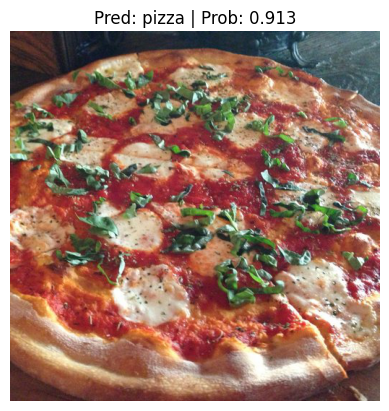

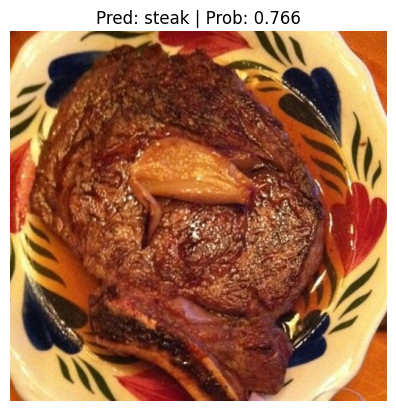

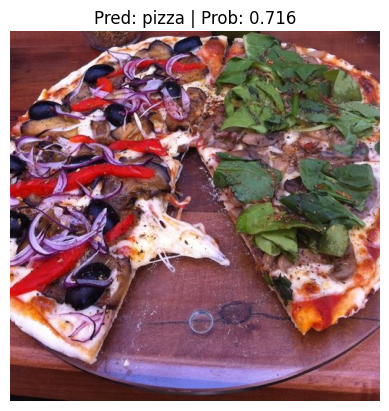

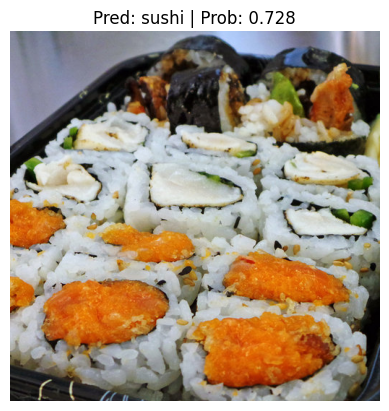

In [19]:
from going_modular import predictions
import random

# Get a random list of 3 image path names from the test dataset
num_images_to_plot = 4
test_image_path_list = list(Path(data_20_percent_path / 'test').glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list, k=num_images_to_plot)

for image_path in test_image_path_sample:
    predictions.pred_and_plot_image(model=best_model, 
                                    image_path=image_path, 
                                    class_names=class_names, 
                                    image_size=(224,224))


# 1.6 Predic on Custom Image

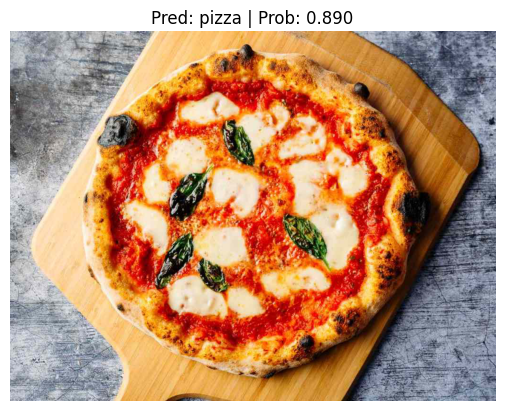

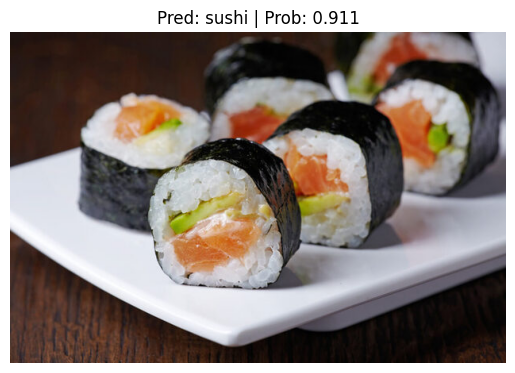

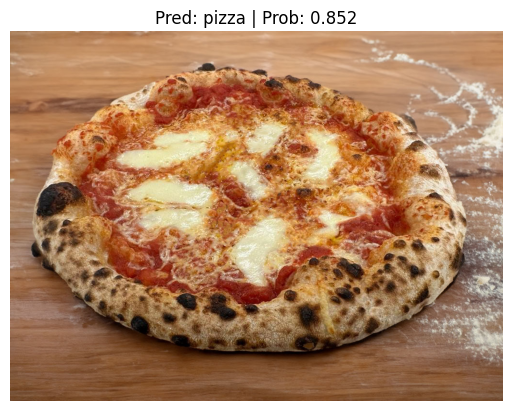

In [22]:
data_path = Path('data/')
for x in list(Path(data_path).glob('*.jpg')):
    predictions.pred_and_plot_image(model=best_model, image_path=x, class_names=class_names, image_size=(224,224))